[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alina-dima/nlp/blob/main/Machine_translation.ipynb)

In [1]:
!pip install datasets transformers

import datasets
import numpy as np
import ast
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


c:\Python3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
def labels_to_text(labels_string):
    return [label_values_single[i] for i in range(len(label_values_single)) if labels_string[i] == 1]

def create_argument_1(row):
    conclusion = row['Conclusion'].rstrip('.').lower()
    premise = row['Premise'].rstrip('.').lower()
    stance = row['Stance']
    argument = f"The premise {premise} is {stance} the conclusion that {conclusion}. The human value {', '.join(row['Labels_text'])} supports this argument."
    argument_with_mask = f"The premise {premise} is {stance} the conclusion that {conclusion}. The human value [MASK] supports this argument."
    return argument, argument_with_mask


def create_argument_2(row):
    premise = row['Premise'].rstrip('.').lower()
    argument = f"The premise {premise} resonates with the human value of {', '.join(row['Labels_text'])}."
    argument_with_mask = f"The premise {premise} resonates with the human value of [MASK]."
    return argument, argument_with_mask

    
data = datasets.load_dataset('webis/Touche23-ValueEval')
label_values = ["Self-direction: thought", "Self-direction: action", "Stimulation", "Hedonism", "Achievement", "Power: dominance", "Power: resources", "Face", "Security: personal", "Security: societal", "Tradition", "Conformity: rules", "Conformity: interpersonal", "Humility", "Benevolence: caring", "Benevolence: dependability", "Universalism: concern", "Universalism: nature", "Universalism: tolerance", "Universalism: objectivity"]
label_values_single = ["thought", "action", "Stimulation", "Hedonism", "Achievement", "dominance", "resources", "Face", "personal", "societal", "Tradition", "rules", "interpersonal", "Humility", "caring", "dependability", "concern", "nature", "tolerance", "objectivity"]

data_train = data['train'].to_pandas()
data_train['Labels_text'] = data_train['Labels'].map(lambda x: labels_to_text(x))

data_train['Argument_1'], data_train['Argument_1_mask'] = zip(*data_train.apply(create_argument_1, axis=1))
data_train['Argument_2'], data_train['Argument_2_mask'] = zip(*data_train.apply(create_argument_2, axis=1))

data_train.head()

No config specified, defaulting to: touche23-value_eval/main
Found cached dataset touche23-value_eval (C:/Users/stefa/.cache/huggingface/datasets/webis___touche23-value_eval/main/0.0.2/109738f7f54e5a68f95e3d0b4d07797f6b7e558edce5e29c71cf0668208bfa43)
100%|██████████| 3/3 [00:00<00:00, 999.20it/s]


,Argument ID,Conclusion,Stance,Premise,Labels,Labels_text,Argument_1,Argument_1_mask,Argument_2,Argument_2_mask
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",[societal],The premise we should ban human cloning as it ...,The premise we should ban human cloning as it ...,The premise we should ban human cloning as it ...,The premise we should ban human cloning as it ...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",[personal],The premise fast food should be banned because...,The premise fast food should be banned because...,The premise fast food should be banned because...,The premise fast food should be banned because...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[dominance, societal]",The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[societal, rules, concern]",The premise capital punishment is sometimes th...,The premise capital punishment is sometimes th...,The premise capital punishment is sometimes th...,The premise capital punishment is sometimes th...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[personal, caring, concern]",The premise factory farming allows for the pro...,The premise factory farming allows for the pro...,The premise factory farming allows for the pro...,The premise factory farming allows for the pro...


In [3]:
data_train_exploded = data_train.explode('Labels_text')
data_train_exploded = data_train_exploded.reset_index(drop=True)

data_train_exploded.head()

,Argument ID,Conclusion,Stance,Premise,Labels,Labels_text,Argument_1,Argument_1_mask
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",societal,The premise we should ban human cloning as it ...,The premise we should ban human cloning as it ...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",personal,The premise fast food should be banned because...,The premise fast food should be banned because...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",dominance,The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...
3,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",societal,The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...
4,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",societal,The premise capital punishment is sometimes th...,The premise capital punishment is sometimes th...


# Model for mask prediction

In [45]:
model_checkpoint = "distilbert-base-uncased"
distilbert_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


def get_predictions(column):

    predictions = []

    for text in data_train[column]:

        inputs = distilbert_tokenizer(text, return_tensors="pt")
        token_logits = distilbert_model(**inputs).logits
        # Find the location of [MASK] and extract its logits
        mask_token_index = torch.where(inputs["input_ids"] == distilbert_tokenizer.mask_token_id)[1]
        mask_token_logits = token_logits[0, mask_token_index, :]
        # Pick the [MASK] candidates with the highest logits
        top_tokens = torch.topk(mask_token_logits, 10, dim=1).indices[0].tolist()

        pred = []
        for token in top_tokens:
            pred.append(distilbert_tokenizer.decode([token]))

        predictions.append(pred)

    return predictions


predictions_1 = get_predictions("Argument_1_mask")
predictions_2 = get_predictions("Argument_2_mask")

predictions_2

[['humanity',
  'life',
  'humans',
  'survival',
  'society',
  'immortality',
  'dna',
  'mankind',
  'happiness',
  'clones'],
 ['food',
  'meat',
  'eating',
  'nutrition',
  'foods',
  'it',
  'consumption',
  'obesity',
  'cooking',
  'health'],
 ['capitalism',
  'democracy',
  'society',
  'humanity',
  'money',
  'mankind',
  'wealth',
  'globalization',
  'civilization',
  'morality'],
 ['justice',
  'punishment',
  'crime',
  'humanity',
  'life',
  'violence',
  'morality',
  'capital',
  'crimes',
  'society'],
 ['subsistence',
  'farming',
  'agriculture',
  'food',
  'production',
  'livelihood',
  'living',
  'poverty',
  'survival',
  'capitalism'],
 ['peace',
  'humanity',
  'mankind',
  'war',
  'survival',
  'civilization',
  'democracy',
  'freedom',
  'terrorism',
  'conflict'],
 ['prayer',
  'religion',
  'scripture',
  'god',
  'faith',
  'salvation',
  'worship',
  'christianity',
  'spirituality',
  'jesus'],
 ['life',
  'society',
  'justice',
  'survival',
  

# Map prediction to classes using word2vec

In [46]:
from gensim import models
import numpy as np
from gensim.models import KeyedVectors

word2vec_path = "C:\Work\RUG\Master\Language technology project\GoogleNews-vectors-negative300.bin" # get this from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [47]:

def map_words_to_classes(candidate_words, classes, num_classes):
    mappings = []

    for candidate_word in candidate_words:
        similarity_scores = []
        for class_word in classes:
            if candidate_word in model and class_word in model:
                similarity = model.similarity(candidate_word, class_word)
                similarity_scores.append(similarity)

    similarity_scores = np.array(similarity_scores)
    classes = np.array(classes)
    top_indices = np.argsort(similarity_scores)[-num_classes:]
    top_classes = [classes[i] for i in top_indices]
    # print(top_classes)
    mappings.append(top_classes)

    return mappings

labels = list(data_train["Labels_text"])

all_mappings_1 = []
for pred, lab in zip(predictions_1, labels):
    word_mappings = map_words_to_classes(pred, label_values_single, len(lab))
    all_mappings_1.append(word_mappings[0])

all_mappings_2 = []
for pred, lab in zip(predictions_2, labels):
    word_mappings = map_words_to_classes(pred, label_values_single, len(lab))
    all_mappings_2.append(word_mappings[0])



In [59]:
data_train["Prediction_1"] = all_mappings_1
data_train["Prediction_2"] = all_mappings_2
data_train.head()

,Argument ID,Conclusion,Stance,Premise,Labels,Labels_text,Argument_1,Argument_1_mask,Argument_2,Argument_2_mask,Prediction_2,Prediction_1,Pred_1_one_hot,Pred_2_one_hot
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",[societal],The premise we should ban human cloning as it ...,The premise we should ban human cloning as it ...,The premise we should ban human cloning as it ...,The premise we should ban human cloning as it ...,[dominance],[rules],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",[personal],The premise fast food should be banned because...,The premise fast food should be banned because...,The premise fast food should be banned because...,The premise fast food should be banned because...,[societal],[rules],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[dominance, societal]",The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...,"[objectivity, societal]","[rules, resources]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[societal, rules, concern]",The premise capital punishment is sometimes th...,The premise capital punishment is sometimes th...,The premise capital punishment is sometimes th...,The premise capital punishment is sometimes th...,"[caring, nature, societal]","[Face, action, concern]","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[personal, caring, concern]",The premise factory farming allows for the pro...,The premise factory farming allows for the pro...,The premise factory farming allows for the pro...,The premise factory farming allows for the pro...,"[Hedonism, tolerance, societal]","[concern, tolerance, societal]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [58]:
def one_hot_encode(words):
    encoding = np.zeros(len(label_values_single), dtype=int)
    for word in words:
        if word in label_values_single:
            encoding[label_values_single.index(word)] = 1
    return encoding

data_train['Pred_1_one_hot'] = data_train['Prediction_1'].apply(lambda x: one_hot_encode(x))
data_train['Pred_2_one_hot'] = data_train['Prediction_2'].apply(lambda x: one_hot_encode(x))

data_train.head()

,Argument ID,Conclusion,Stance,Premise,Labels,Labels_text,Argument_1,Argument_1_mask,Argument_2,Argument_2_mask,Prediction_2,Prediction_1,Pred_1_one_hot,Pred_2_one_hot
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",[societal],The premise we should ban human cloning as it ...,The premise we should ban human cloning as it ...,The premise we should ban human cloning as it ...,The premise we should ban human cloning as it ...,[dominance],[rules],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",[personal],The premise fast food should be banned because...,The premise fast food should be banned because...,The premise fast food should be banned because...,The premise fast food should be banned because...,[societal],[rules],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[dominance, societal]",The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...,The premise sometimes economic sanctions are t...,"[objectivity, societal]","[rules, resources]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[societal, rules, concern]",The premise capital punishment is sometimes th...,The premise capital punishment is sometimes th...,The premise capital punishment is sometimes th...,The premise capital punishment is sometimes th...,"[caring, nature, societal]","[Face, action, concern]","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[personal, caring, concern]",The premise factory farming allows for the pro...,The premise factory farming allows for the pro...,The premise factory farming allows for the pro...,The premise factory farming allows for the pro...,"[Hedonism, tolerance, societal]","[concern, tolerance, societal]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


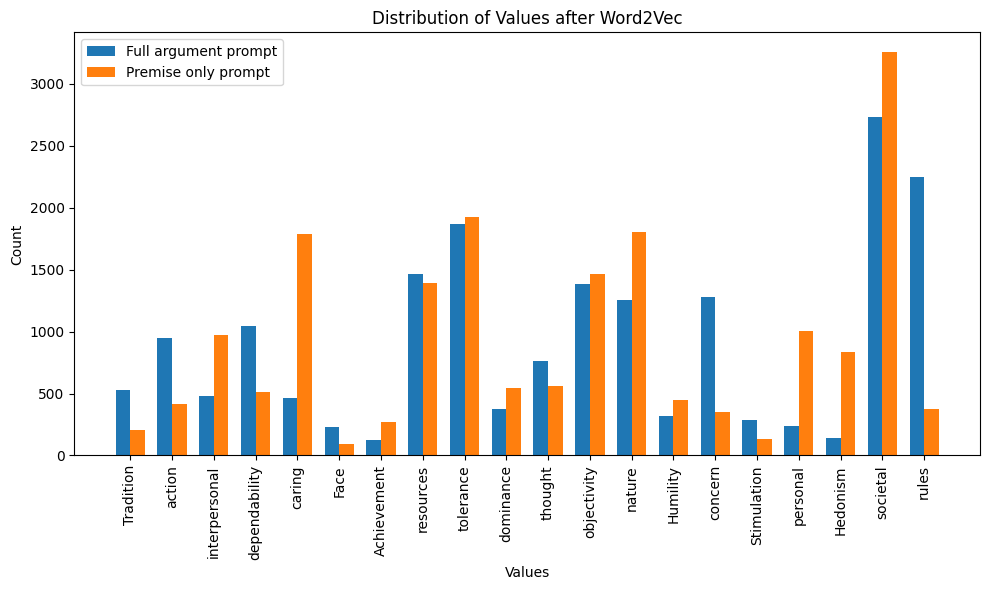

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

flat_strings1 = [item for sublist in data_train['Prediction_1'] for item in sublist]
flat_strings2 = [item for sublist in data_train['Prediction_2'] for item in sublist]

string_counts1 = pd.Series(flat_strings1).value_counts()
string_counts2 = pd.Series(flat_strings2).value_counts()

unique_strings = list(set(string_counts1.index) | set(string_counts2.index))

string_counts1 = string_counts1.reindex(unique_strings, fill_value=0)
string_counts2 = string_counts2.reindex(unique_strings, fill_value=0)

x = np.arange(len(unique_strings))

width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, string_counts1, width, label='Full argument prompt')
rects2 = ax.bar(x + width/2, string_counts2, width, label='Premise only prompt')

ax.set_xlabel('Values')
ax.set_ylabel('Count')
ax.set_title('Distribution of Values after Word2Vec')
ax.set_xticks(x)
ax.set_xticklabels(unique_strings, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

In [10]:
print("Mean length is:",data_train_exploded.Argument_1.str.len().mean())
print("Min length is:",data_train_exploded.Argument_1.str.len().min())
print("Max length is:",data_train_exploded.Argument_1.str.len().max())

Mean length is: 300.41326002939417
Min length is: 151
Max length is: 959


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertForMaskedLM: ['vocab_transform', 'vocab_projector', 'distilbert', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForMaskedLM were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert', 'mlm___cls']
You should pro

dict_keys(['input_ids', 'attention_mask'])
Epoch 1/10
1/1 [==============================] - 18s 18s/step - loss: 10.3936
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 9.2634
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 8.7254
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 8.3964
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 7.9737
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 7.4422
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 6.9668
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 6.5917
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 6.1361
Epoch 10/10
1/1 [==============================] - 1s 1s/step - loss: 5.7269


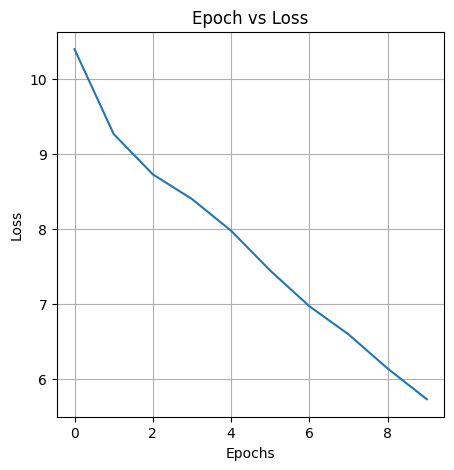

In [11]:
from transformers import BertTokenizer, TFBertForMaskedLM
import tensorflow as tf
import os
import numpy as np
import re
import matplotlib.pyplot as plt


arguments_concat = ' '.join(data_train_exploded["Argument_1"]) 
arguments_concat_masked = ' '.join(data_train_exploded["Argument_1_mask"]) 


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = TFBertForMaskedLM.from_pretrained("distilbert-base-uncased")

inputs = tokenizer(arguments_concat, max_length=300,truncation=True,padding='max_length',return_tensors='tf')
inputs_masked = tokenizer(arguments_concat_masked, max_length=300,truncation=True,padding='max_length',return_tensors='tf')

print(inputs.keys())

inputs['labels'] = inputs['input_ids']
inputs['input_ids'] = inputs_masked['input_ids']
inputs.keys()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit([inputs.input_ids,inputs.attention_mask],inputs.labels,verbose=1,batch_size=64,epochs=10)

losses = history.history['loss']
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)),losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()

In [12]:
from transformers import pipeline

text = '''I like [MASK]'''


mask_filler = pipeline("fill-mask", model=model, tokenizer=tokenizer)

preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred['token_str']} - score: {pred['score']}")

>>> . - score: 0.007760515436530113
>>> that - score: 0.0007546591805294156
>>> we - score: 0.000491123937536031
>>> human - score: 0.00048103384324349463
>>> ##olis - score: 0.00037032924592494965


In [13]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModelForMaskedLM,DataCollatorForLanguageModeling
# from torch.optim import AdamW
# from accelerate import Accelerator
# from torch.utils.data import DataLoader
# from transformers import default_data_collator


# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")
# optimizer = AdamW(model.parameters(), lr=5e-5)
# data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

# arguments_concat = {}
# arguments_concat_masked = {}

# for split in data.keys():
#     arguments_concat[split] = ' '.join(data_exploded[split]["Argument_1"]) 
#     arguments_concat_masked[split] = ' '.join(data_exploded[split]["Argument_1_mask"]) 

# def encode(str_input):
#     return tokenizer(str_input, max_length=300,truncation=True,padding='max_length',return_tensors='pt')


# tokenized_data = tokenized_data_masked = {}

# for split in data.keys():
#     tokenized_data[split] = tokenizer(arguments_concat[split], max_length=300,truncation=True,padding='max_length',return_tensors='pt')
#     tokenized_data_masked[split] = tokenizer(arguments_concat_masked[split], max_length=300,truncation=True,padding='max_length',return_tensors='pt')

# data_masked = tokenized_data.copy()
# for split in data.keys():
#     tokenized_data[split]['labels'] = tokenized_data[split]['input_ids']
#     tokenized_data[split]['input_ids'] = tokenized_data_masked[split]['input_ids']

# if torch.cuda.is_available():
#     model = model.to('cuda')

# training_args = TrainingArguments(
#     output_dir="yay-finetuned",
#     overwrite_output_dir=True,
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     weight_decay=0.01,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_data["training"],
#     eval_dataset=tokenized_data["validation"],
#     data_collator=data_collator,
#     tokenizer=tokenizer,
# )


# trainer.train()
# model.save_pretrained("test")